In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import rdkit
from sklearn.metrics import mean_squared_error, r2_score
from utils import DataSet, generate_features_for_smiles, grid_search, plot_results

pd.set_option('display.max_rows', None)

In [7]:
lec_data = DataSet(target="LogExtCoeff", fill_na="drop", drop_features=["Ipc"])




this part is working


In [8]:
def smarts_from_substructure_smiles(substructure_smiles):
    substructure_mol = rdkit.Chem.MolFromSmiles(substructure_smiles)
    substructure_smarts = rdkit.Chem.MolToSmarts(substructure_mol)
    print (f"substructure_smarts is {substructure_smarts}")
    substructure_mol = rdkit.Chem.MolFromSmarts(substructure_smarts)
    return substructure_mol, substructure_smarts

substructure_smarts is [#6]1-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-1


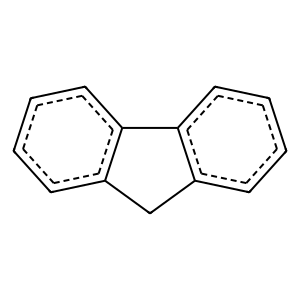

In [9]:
# Input the smiles string of interest:
fluorene_smiles = 'C1C2=CC=CC=C2C3=CC=CC=C31'
fluorene_mol, fluorene_smarts = smarts_from_substructure_smiles(fluorene_smiles)
# Then plot the substructure to check it is correct (visually)
rdkit.Chem.Draw.MolToImage(fluorene_mol)


In [13]:
lec_data.y.head()

,SMILES,SELFIES,LogExtCoeff
97,c1ccc2ccccc2c1,[C][=C][C][=C][C][=C][C][=C][C][Ring1][=Branch...,3.58
98,C[Si](C)(C)c1cccc2ccccc12,[C][Si][Branch1][C][C][Branch1][C][C][C][=C][C...,3.73
99,C[SiH](C)c1cccc2ccccc12,[C][SiH1][Branch1][C][C][C][=C][C][=C][C][=C][...,3.75
100,CCCC[Si](C)(C)c1cccc2ccccc12,[C][C][C][C][Si][Branch1][C][C][Branch1][C][C]...,3.74
101,CC(C)(C)[Si](C)(C)c1cccc2ccccc12,[C][C][Branch1][C][C][Branch1][C][C][Si][Branc...,3.78


In [14]:
lec_data.X.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
97,2.120370,2.120370,1.310185,1.310185,0.511431,128.174,120.110,128.062600,48,0,...,0,0,0,0,0,0,0,0,0,0
98,2.397593,2.397593,1.197755,-1.197755,0.619051,200.357,184.229,200.102127,72,0,...,0,0,0,0,0,0,0,0,0,0
99,2.376759,2.376759,0.679074,-0.679074,0.600400,186.330,172.218,186.086477,66,0,...,0,0,0,0,0,0,0,0,0,0
100,2.504398,2.504398,1.264830,-1.264830,0.689738,242.438,220.262,242.149077,90,0,...,0,0,0,0,0,0,0,0,0,0
101,2.480926,2.480926,0.386036,-1.445440,0.643330,242.438,220.262,242.149077,90,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# remove all rows where fluorene is not a substructure of the molecule
# first add a column 'mol' to the dataframe
lec_data.y['mol'] = lec_data.y['SMILES'].apply(rdkit.Chem.MolFromSmiles)
lec_data.y['hasfluorene']= lec_data.y['mol'].apply(lambda banana: banana.HasSubstructMatch(fluorene_mol))
# reset the index
# lec_data.y = lec_data.y.reset_index(drop=True)
# now drop the 'mol' column
# lec_data.X = lec_data.X.drop(columns=['mol'])
# print (len(lec_data.X))
# lec_data.y.head()
filtered_y = lec_data.y[lec_data.y['hasfluorene']==True]
filtered_x = lec_data.X[lec_data.y['hasfluorene']==True]
filtered_y.head()

,SMILES,SELFIES,LogExtCoeff,mol,hasfluorene
635,CC1(C)c2ccccc2-c2ccc(N3c4ccc(-c5ccc(/C=C6\C(=O...,[C][C][Branch1][C][C][C][=C][C][=C][C][=C][Rin...,4.792392,<rdkit.Chem.rdchem.Mol object at 0x287cdc6d0>,True
636,CCCCCCc1cc(-c2ccc3c(c2)C2CCCC2N3c2ccc3c(c2)C(C...,[C][C][C][C][C][C][C][C][=C][Branch2][Ring2][S...,4.908485,<rdkit.Chem.rdchem.Mol object at 0x287cdc740>,True
1138,F[B-]1(F)OC(c2ccc3c(c2)Cc2ccccc2-3)=CC(c2ccccc...,[F][B-1][Branch1][C][F][O][C][Branch2][Ring1][...,4.805501,<rdkit.Chem.rdchem.Mol object at 0x287ce3740>,True
1139,COc1ccc(C2=[O+][B-](F)(F)OC(c3ccc4c(c3)Cc3cccc...,[C][O][C][=C][C][=C][Branch2][Ring2][Branch2][...,4.855519,<rdkit.Chem.rdchem.Mol object at 0x287ce37b0>,True
1189,CCCCCCC1(CCCCCC)c2ccccc2-c2ccc(-c3ccc(-c4cc(-c...,[C][C][C][C][C][C][C][Branch1][#Branch1][C][C]...,4.560000,<rdkit.Chem.rdchem.Mol object at 0x287ce3a50>,True


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(filtered_x, filtered_y, test_size=0.2, random_state=42)

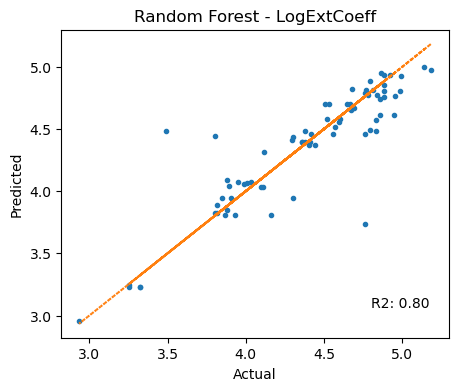

MSE: 0.05199188146194744


In [28]:
rf = RandomForestRegressor(200, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train["LogExtCoeff"])

y_pred = rf.predict(X_test)

plot_results(
    y=y_test["LogExtCoeff"],
    y_hat=y_pred,
    title=f"Random Forest - LogExtCoeff",
)
print(f"MSE: {mean_squared_error(y_test['LogExtCoeff'], y_pred)}")

In [24]:
# now look at fluorene test data
# load belfield_LMA.parquet
belfield_LEC = pd.read_parquet('data/belfield_LEC.parquet')
# rename LMA column to "LambdaMaxAbs"
belfield_LEC.rename(columns={'LEC': 'LogExtCoeff'}, inplace=True)
belfield_LEC.head()

,smiles,LogExtCoeff
23,C=1C=CC(=CC1)N(C=2C=CC=CC2)C3=CC=C(C=CC=4C=CC=...,5.000000
26,C=1C=CC(=CC1)N(C=2C=CC=CC2)C3=CC=C(C=CC=4C=CC5...,5.000000
28,C=1C=CC(=CC1)N(C=2C=CC=CC2)C3=CC=C(C=CC4=CC=C5...,5.477121
29,O=N(=O)C1=CC=C2C3=CC=C(C=CC4=CC=C5C6=CC=C(C=C6...,4.582745
30,N1=C(SC2=CC=CC=C12)C3=CC=C4C5=CC=C(C=CC6=CC=C7...,5.012837


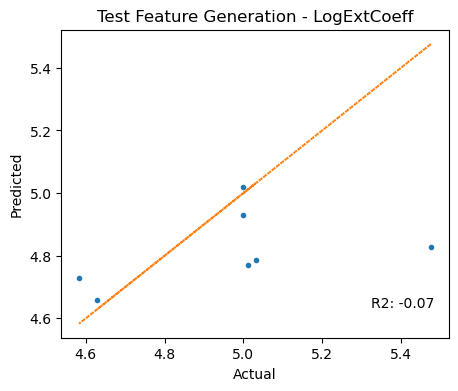

MSE: 0.08113414262681197


In [31]:
# Testing feature generation functions with belfield dataset
smiles_belfield = belfield_LEC['smiles'].tolist()

belfield_features_df = generate_features_for_smiles(
    smiles_belfield,
    descriptors=rf.feature_names_in_, # type: ignore
    missing_value=None,
    log_missing=True)

pred_from_features = rf.predict(belfield_features_df)

plot_results(
    y=belfield_LEC["LogExtCoeff"],
    y_hat=pred_from_features,
    title=f"Test Feature Generation - LogExtCoeff",
)
print(f"MSE: {mean_squared_error(belfield_LEC['LogExtCoeff'], pred_from_features)}")